# How should we price homes in Seattle?

## Goals

In the previous case, we learned how linear regression can be a powerful tool to understand the behavior of a variable of interest as being explained by other variables in our dataset. However, in many real instances, our data may not meet basic assumptions that one needs for a linear regression model to be suitable. In cases where linear regression is not *directly* applicable in these scenarios, we need to figure out how to go around this problem.

In this case, you will learn:

1. How to select and use appropriate variable transformations to correct our data such that it becomes applicable for linear regression
2. How to decide whether the addition of predictor variables actually benefit the model or create overfitting
3. How to further extend the applicability of linear models by taking into account non-linear interactions that can exist between the predictor variables

In [1]:
# Ignore user warnings
import warnings
warnings.simplefilter("ignore", UserWarning)

# Load relevant packages
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab

%matplotlib inline
plt.style.use('ggplot')

## Introduction

**Business Context.** You have been hired as a data scientist by a large real estate company in their Seattle office. Your job is to assist Seattle residents willing to sell their home with determining an optimal price to sell their property at in order to maximize their proceeds while still being able to find willing buyers. To do this, the firm would like you to build a pricing model for Seattle real estate, in order to maximize the probability of helping residents close sales (and thus maximizing commissions for the firm).

**Business Problem.** Your task is to **build a model that uses past sales data in Seattle to recommend an optimal sell price for any particular property**.

**Analytical Context.** The provided dataset was retrieved from Kaggle (https://www.kaggle.com/harlfoxem/housesalesprediction) and includes sales prices of houses in the state of Washington (King county, where Seattle is located) between May 2014 and May 2015. As we have learned, the primary tool to predict a response variable is the multiple regression model. However, sometimes the assumptions of a linear model are not met by our data. We will learn a set of strategies to mitigate some common issues that appear during regression analysis.

The case is structured as follows: you wil (1) conduct basic EDA of some of the variables to determine that standard linear regression is not sufficient; (2) learn about variable transformations and use these to improve the initial model; and finally (3) learn how to incorporate interaction effects (which are themselves a form of variable transformation involving two or more variables) into our model.

## Data exploration

Let's start by reviewing the columns of the dataset and what they mean:

1. **id**: identification for a house
2. **date**: date house was sold
3. **price**: price house was sold at
4. **bedrooms**: number of bedrooms
5. **bathrooms**: number of bathrooms
6. **sqft_living**: square footage of the home
7. **sqft_lot**: square footage of the lot
8. **floors**: total floors (levels) in house
9. **waterfront**: whether or not the house has a view of a waterfront
10. **view**: an index from 0 to 4 of how good the view from the property is
11. **condition**: how good the condition of the house is
12. **grade**: overall grade given to the housing unit, based on King County grading system
13. **sqft_above**: square footage of the house apart from basement
14. **sqft_basement**: square footage of the basement
15. **yr_built**: year house was built
16. **yr_renovated**: year house was renovated
17. **zipcode**: zipcode of the house
18. **lat**: latitude coordinate of the house
19. **long**: longitude coordinate of the house

(See also [here](https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices) for a complete explanation of the columns.)

In [2]:
houses = pd.read_csv('kc_house_data.csv')

In [3]:
houses.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Exercise 1:

#### 1.1

Analyze the distribution of house prices using `.describe()` and a histogram plot. What do you see? Based solely on these results, would you say that the distribution of prices is Gaussian?

Text(0.5, 1.0, 'Histogram of prices')

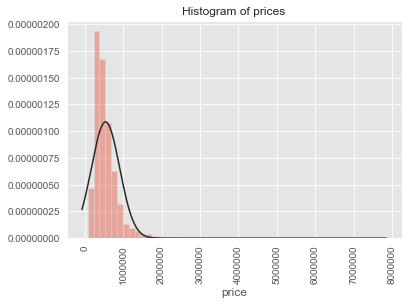

In [4]:
houses['price'].describe()
## histogram plot of price
#sns.distplot(houses['price'],fit=stats.laplace, kde=False)
sns.distplot(houses['price'],fit=stats.norm, kde=False)
sns.set(color_codes=True)
plt.xticks(rotation=90)
plt.title("Histogram of prices")

**Answer.**
From the histogram we can see a wide range in the prices of houses. For instance, there is a house that is worth almost $8 million, which is around 20 standard deviations away from the mean of $540,000. This is quite large considering that in a Gaussian distribution 3 standard deviations from the mean is enough to contain 99.7% of the population. However, from the plot it is not easy to see whether we have many houses exceeding the 3 standard deviation mark or if we just have a couple of outliers that are skewing the plot.

-----------

#### 1.2

One way to assess if data comes from a particular given distribution is by drawing a **Quantile-Quantile plot** (QQ-plot). In a QQ-plot, the quantiles of the data are plotted against the quantiles of the desired distribution. In principle, if the resulting plot is far from being the identity (i.e. the line $y=x$), we can say that our data does not follow the desired distribution.  

Use the function ```stats.probplot(x, dist="norm",plot=plt)``` to verify if the prices of the houses follow a Gaussian distribution.

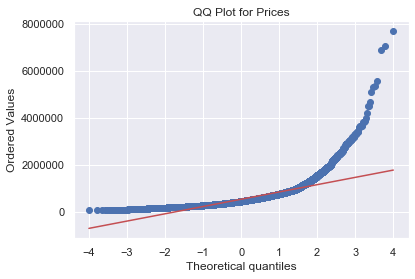

In [5]:
## QQ plot of price
stats.probplot(x=houses['price'], dist = "norm", plot = plt)
plt.title("QQ Plot for Prices")
plt.show()

**Answer.** 
The distribution does not look Gaussian. Looking at both the QQ plot and the histogram, we can see that the distribution of our data is heavily skewed.

-----------

### Exercise 2:

Analyze the relationship between house prices and price per square foot of living space. What can you conclude? (Hint: use the `lmplot()` function in the `seaborn` library.)

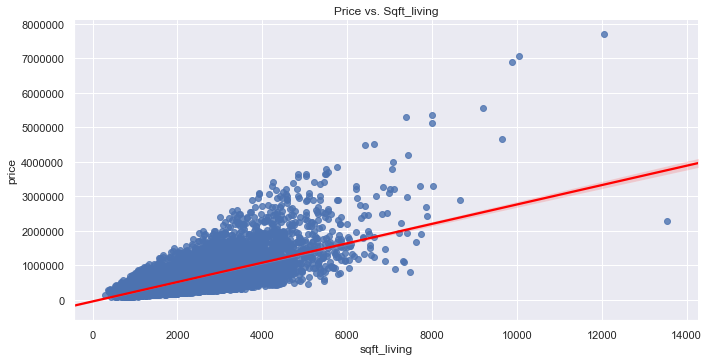

In [6]:
## linear relation between sqft_living and price
sns.lmplot(x='sqft_living',y='price',data=houses, 
           line_kws = {'color': "red"} ,aspect= 2)
plt.title("Price vs. Sqft_living");

**Answer.**
Given the way that house price vs. price per square foot seems to "fan out", we see that the relationship does not appear to be linear. In fact, it is not immediately obvious what sort of relationship is exhibited at all here.

-----------

## Variable transformation

We have seen in Exercise 1 that the distribution of house prices is not Gaussian, and that this may be contributing to the "fanning out" effect we observed in Exercise 2. We want to find a way to remove the "fanning out" effect, as it implies that a linear fit becomes less and less suitable, with higher and higher variance from the line of best fit for large values of the predictor and response variables. A common method of addressing this issue is to transform the response variable and/or the predictor variable. Such a **variable transformation** involves applying a known function to one or more of these variables to achieve conditions that are suitable for the application of a linear model.

Typical mathematical functions used to transform variables include powers (quadratic, cubic, square root, etc.), logarithms, and trigonometric functions. Let's start with the logarithmic transformation to see if we can achieve some results.

### Exercise 3:

Take the logarithm of house prices and create plots to ascertain if this makes the distribution of the transformed variable roughly Gaussian.

**Hint:** Use the function ```np.log```.

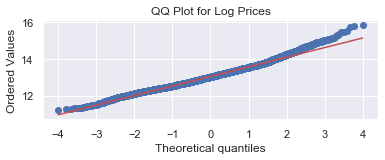

count    21613.000000
mean        13.047817
std          0.526685
min         11.225243
25%         12.682152
50%         13.017003
75%         13.377006
max         15.856731
Name: price, dtype: float64

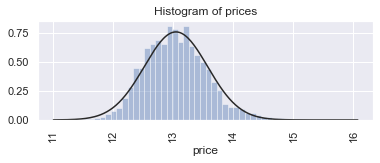

In [7]:
## QQ plot of price
plt.subplot(2,1,1)
stats.probplot(np.log(houses['price']), dist = "norm", plot = plt)
plt.title("QQ Plot for Log Prices")
plt.show()
plt.subplot(2,1,2)
sns.distplot(np.log(houses['price']),fit=stats.norm, kde=False)
sns.set(color_codes=True)
plt.xticks(rotation=90)
plt.title("Histogram of prices")
np.log(houses['price']).describe()

**Answer.**

-----------

### Building a linear model with transformed variables

Of course, we aren't just restricted to applying the logarithmic transformation to house prices; we can do it to any other variable in our dataset. Let's transform both house prices and price per square foot by this method and interpret the resulting linear model:

In [8]:
mod1 = smf.ols(formula='np.log(price) ~ np.log(sqft_living)', data=houses).fit()
print(mod1.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                 1.808e+04
Date:                Tue, 07 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:03:33   Log-Likelihood:                -10240.
No. Observations:               21613   AIC:                         2.048e+04
Df Residuals:                   21611   BIC:                         2.050e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.7299    

In this case interpretation of coeficcient is: a 1% increase in sqt_living increases price by 0.83%. This kind of interpretation only applies if both x and y are transformed to logs

We have to be mindful of how we interpret the coefficients. Although we could say that our results tell us that a 1 unit increase in the logarithm of living space will result in a 0.836 increase in the logarithm of the price, this is a very mechanical and not at all intuitive interpretation.

Mathematics can help us come up with a more intuitive interpretation. Let us denote by $P$ and $S$ the price and square footage of a house. Then, the fit our above model has come up with is 

$$
\begin{aligned}
\log(P)&=0.84 \log(S)+6.73,\\
P&=e^{6.74}S^{0.84}.\\
\end{aligned}
$$

This is a nonlinear relationship, so it's not as straightforward as saying "increasing $S$ by 1 means that $P$ goes up by $x$". However, we can try reframing this in percentage terms; i.e. how does a 1 percent increase in $S$ affect price? We can see this by calculating the price $P_0$ of a house with $S_0=(1.01)S$ square feet using our model:

$$
\begin{aligned}
P_0&=e^{6.74}S_0^{0.84},\\
&=(e^{6.74}S^{0.84})(1.01)^{0.84},\\
&\approx (1.0084) P. \\
\end{aligned}
$$

Thus, a 1 percent increase in living space results in a 0.84 percent increase in price. This percentage vs. percentage change comparison is known as **elasticity**.

Let's now build a linear model where the logarithmic transform is only applied to the house prices:

In [9]:
mod2 = smf.ols(formula='np.log(price) ~ sqft_living', data=houses).fit()
print(mod2.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                 2.023e+04
Date:                Tue, 07 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:03:38   Log-Likelihood:                -9670.2
No. Observations:               21613   AIC:                         1.934e+04
Df Residuals:                   21611   BIC:                         1.936e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.2185      0.006   1916.883      

The interpretation of the regression coefficient is once again different. We interpret the coefficient as a **semi-elasticity**, where an absolute increase in `sqft_living` (because it has not had the logarithm function applied to it) corresponds to a percentage increase `price`:

$$
\begin{aligned}
\begin{aligned}
\log(P)&=0.0004 S+12.12,\\
P&=e^{12.12}e^{0.0004S},\\
\end{aligned} \quad  & \text{thus, } \quad
\begin{aligned}
P_0&=e^{12.12}e^{0.0004(S+1)},\\
P_0&=e^{0.0004}P\approx (1.0004)P.\\
\end{aligned}
\end{aligned}
$$

Specifically, here we can say that an increase in living space by 1 square foot leads to a 0.04% percent increase in price.

### Exercise 4:

Below we have used the ```sns.regplot()``` function (similar to ```sns.lmplot()```) to plot the ```log_price``` of houses against ```log_sqrt_living``` and ```sqrt_living```.  From these plots, which of the two linear models above is "more linear"?

Text(0.5, 1.0, 'Log-Price vs. Sqft_living')

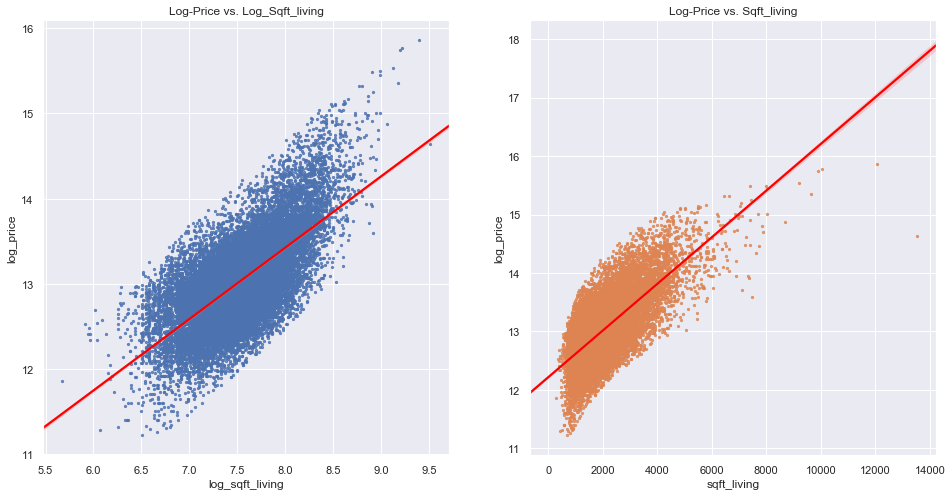

In [10]:
houses['log_price'] = np.log(houses['price'])
houses['log_sqft_living'] = np.log(houses['sqft_living'])

figure, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,8))

sns.regplot(x='log_sqft_living',y='log_price',data=houses, 
           line_kws = {'color': "red"} , scatter_kws={"s": 5},ax=axes[0]) 
axes[0].set_title("Log-Price vs. Log_Sqft_living")

sns.regplot(x='sqft_living',y='log_price',data=houses, 
           line_kws = {'color': "red"} , scatter_kws={"s": 5}, ax=axes[1])
axes[1].set_title("Log-Price vs. Sqft_living")

**Answer.** We can see from these plots that the data points of the log-log model cluster more uniformly around the line of best fit across different levels of the predictor variable as compared to the other model, suggesting that the log-log model is more linear.



-----------

### Box-Cox transformation

Logarithmic transformations are just one of the possible transformations that we discussed. Earlier, we mentioned powers (e.g. squares, cubes, square roots, etc.) as well as trigonometric functions. In some cases, choosing a transformation can be straightforward (e.g. the logarithm because it is easily interpretable); other times, it is much more difficult. A formal way to decide on which transformation to use is to estimate the coefficient $\lambda$ of the Box-Cox transformation:

$$BC(\lambda) = \frac{Y^\lambda-1}{\lambda} $$

If the estimate of $\lambda$ is close to 2, we can use the quadratic transformation; if it is close to 0.5, the square root transformation; if it is close to zero or less than zero (negative), the logarithmic transformation; etc. In our case, we have:

In [11]:
price,fitted_lambda = stats.boxcox(houses['price'])
round(fitted_lambda,2)

-0.23

This is less than zero, so it would seem that using the logarithmic transformation is sensible.

## Multiple linear regression with transformed variables

Of course, as we have seen from the previous case, it doesn't make sense to restrict ourselves to modeling house prices based on only one predictor variable. Let's add in several more variables, some transformed and some not:

### Exercise 5:

Fit a linear model of log `price` vs. log `sqft_living`, log `sqft_lot`, `bedrooms`, `floors`, `bathrooms`, `waterfront`, `condition`, `view`, `grade`, `yr_built`, `lat`, and `long`. Provide interpretations for the coefficients of log `sqft_living` and `waterfront`.

In [ ]:
houses['waterfront']

In [15]:
mod3 = smf.ols (formula = 'np.log(price) ~ np.log(sqft_living)+ np.log(sqft_lot) +bedrooms + floors + bathrooms +C(waterfront) + condition  + C(view) + grade + yr_built + lat + long ', data = houses).fit()
print(mod3.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     4638.
Date:                Tue, 07 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:04:39   Log-Likelihood:                -1246.2
No. Observations:               21613   AIC:                             2524.
Df Residuals:                   21597   BIC:                             2652.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -38.9925    

**Answer.**

All the variables are statistically significant (all 𝑝 - values less than 0.01). Overall this linear model explains over 76 percent of the total variability of the response variable.
An increase of one percent in living space leads to an increase of 0.4067 percent in price. A property with a water view has an increase in price of 39.94 percent (in fact, 𝑒0.3994≈1.48 e0.3994≈1.48, an increase of almost 48%).
It is worth to note that our model also states that for each additional bedroom, the price of a house decreases by 2%
2%. This might be due to the fact that our model takes into account many variables that already explain the price of houses much better than the number bedrooms (such as square footage, water view and location). Thus, the number of bedrooms may become less informative when predicting the price of a house.
What other factors may impact the price that we have left out? Some that may play a role include proximity to services (hospitals, schools, commercial areas, movie theaters, metro stops...), crime rates, etc. Our dataset does not have a comprehensive list of possible factors; however, we do have some variables that would be interesting to investigate further.
In general, house prices change depending on the location. Two houses with comparable features can be priced very differently depending on the neighborhood and geographic position. In this dataset, we have zipcode and geographic coordinates. Let us start by taking a look at the relationship between latitude and prices.

-----------

What other factors may impact the price that we have left out? Some that may play a role include proximity to services (hospitals, schools, commercial areas, movie theaters, metro stops...), crime rates, etc. Our dataset does not have a comprehensive list of possible factors; however, we do have some variables that would be interesting to investigate further.

In general, house prices change depending on the location. Two houses with comparable features can be priced very differently depending on the neighborhood and geographic position. In this dataset, we have zipcode and geographic coordinates. Let us start by taking a look at the relationship between latitude and prices.

### Exercise 6:

In the plot below we can see the relationship between latitude and the logarithm of house prices. What do you observe?

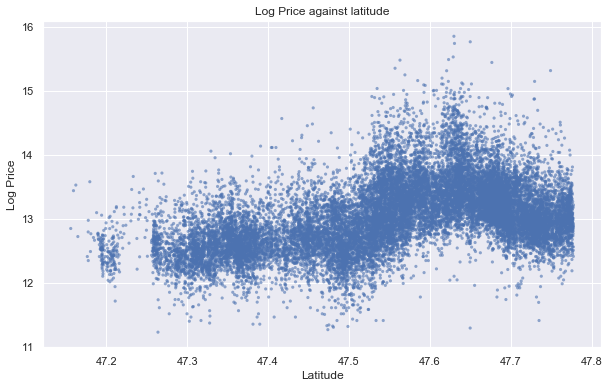

In [16]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.scatter(houses['lat'],np.log(houses['price']),c ='b',alpha=0.6,edgecolors='none',s=10)
plt.xlabel("Latitude")
plt.ylabel("Log Price")
ax.set_title("Log Price against latitude")
plt.show();

**Answer.** We can see that there is a nonlinear relationship between latitude and price. Based on the concave curvature in the right half of the plot above, it seems that adding a quadratic term would be able to help us explain this.

-----------

### Exercise 7:

#### 7.1

Add the square of the latitude as an additional predictor to the model in Exercise 5. Is the term significant? What can you say about the $R^2$ of this model?

In [17]:
## lat square effect
mod4 = smf.ols ( formula = 'np.log(price) ~ np.log(sqft_living)+ np.log(sqft_lot) +bedrooms + floors + bathrooms+ condition + C(waterfront) + C(view) + grade + yr_built + lat + I(lat**2) + long ', data = houses  ).fit()
print(mod4.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     4741.
Date:                Tue, 07 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:04:45   Log-Likelihood:                -525.85
No. Observations:               21613   AIC:                             1086.
Df Residuals:                   21596   BIC:                             1221.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -7714.7455    

**Answer.** We can see that the coefficient is highly significant. The R-squared has increased by about 1%.

-----------

#### 7.2

One of the properties of $R^2$ is that it can never decrease when the set of predictors is increased. In other words, there is no penalty for continuing to add variables to the model. Why do you think this may be a drawback of $R^2$? How would you go about deciding the correct set of predictors to use?


**Answer.**

Since there is no penalty for continuing to add variables, we may end up using variables that have little explanatory power. Consequently, selecting predictor variables trying to maximize 𝑅2 can lead to choosing unnecessarily complex and redundant models. This may lead to overfitting, thus losing the applicability of the model. Remember, "if we torture our data enough, it will talk".


One way we could avoid overfitting is by implementing a measure that penalizes for new added variables which lead to a small increase in 𝑅2. We may try to create several linear models by removing one (or a subset) of the variables at a time and see how the 𝑅2 behaves after the removal. If 𝑅2 decreases below certain threshold we may consider keeping the corresponding variable(s), otherwise we drop the variable(s) as being not informative enough.

-----------

#### 7.3

There are several model selection criteria that quantify the quality of a model by managing the tradeoff between goodness-of-fit and simplicity. The most common one is the **AIC (Akaike Information Criterion)**. The AIC penalizes the addition of more terms to a model, so in order for an updated model to have a better AIC, its $R^2$ needs to improve by at least as much as the additional imposed penalty. **Given several models**, the one with the lowest AIC is the recommended one.

For now, do not worry about the technical details behind AIC (although you are free to look them up yourself). In future cases on **regularization**, you will learn more about the rationale behind why these sorts of estimators matter and how to construct and use them in model-building.

Use the AIC score (you can look up this in the output of the model summary,  or by simply using ```mod.aic```) to evaluate whether or not the fit with the added square term is better than the previous model.

In [25]:
print(mod3.aic)
print(mod4.aic)

2524.3544210847685
1085.6977236031307


**Answer.** Comparing model 3 and model 4 we can see that the AIC has improved from 2597.253 to 1138.814.

-----------

## Modeling interaction effects

As we have seen during the EDA cases, interaction effects can complicate the perceived effect of the predictor variables on the outcome of interest. Let's dig into potential interactions by looking at two of the predictors in tandem: `waterfront` and geographic position (`lat` and `long`). Specifically, is the effect of geographic position different among the houses that have a waterfront view vs. those that do not?

### Exercise 8:

#### 8.1

Below, we have drawn a plot of the relationship between `Log-price` and `lat` using  `lmplot()`. This plot fits two separate regression lines for houses that do and do not have a `waterfront` view. What do you see? Is the relationship the same or different?

Text(0.5, 1, 'Log-price vs. Latitude')

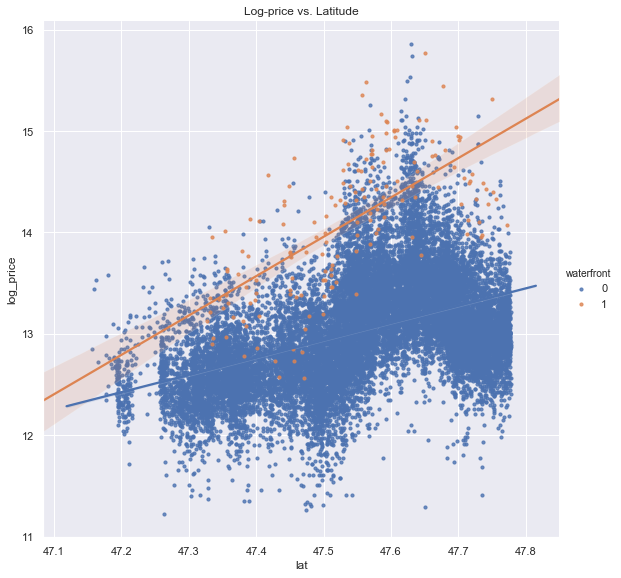

In [26]:
sns.lmplot(x='lat', y='log_price',data=houses, 
           hue="waterfront", height=8, scatter_kws={"s": 10})
plt.title("Log-price vs. Latitude")

**Answer.**

-----------

#### 8.2

Now, we see a plot that fits separate regression lines for houses with different `view` indexes i.e. how good the view of the property was. What do you see? Is the relationship the same or different?

(47.1, 47.8)

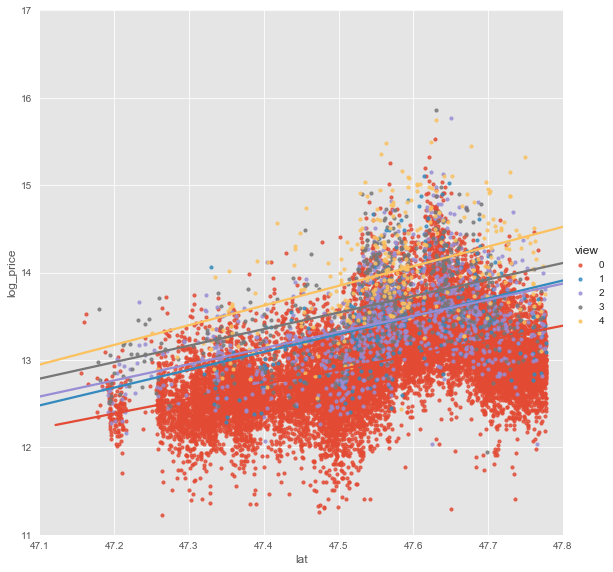

In [10]:
lm=sns.lmplot(x='lat', y='log_price',data=houses, 
           hue="view", height=8, scatter_kws={"s": 10},sharex=False,sharey=False,ci=None)
axes= lm.axes
axes[0,0].set_ylim(11,17)
axes[0,0].set_xlim(47.1,47.8)

**Answer.**

----------

We can verify the findings of Exercise 8 by adding **interaction terms** to our linear model. The interaction term between `lat` and `waterfront` can be added to our model using the syntax `lat*C(waterfront)`:

In [18]:
formula = ('np.log(price) ~ lat*C(waterfront)')
mod5_1 = smf.ols(formula=formula, data=houses).fit()
print(mod5_1.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     2228.
Date:                Tue, 07 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:05:01   Log-Likelihood:                -13898.
No. Observations:               21613   AIC:                         2.780e+04
Df Residuals:                   21609   BIC:                         2.784e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -68

The way we read the interaction effect given by the summary of ```model_5.1``` is as follows:
    
1. `C(waterfront)[T.1]` reads in the same way as before. Here the model states that an adjustment of $102\%$ should be done to the price of a house having a waterfront view. We saw  before that `waterfront` had a positive impact in the price of the house, however our model is probably given more weight to other factors (compare the intercept with previous models) and then correcting this over-estimation.

2. `lat` and `lat:C(waterfront)[T.1]` reads as follows. For each degree of increment in latitude, the price of the house should increase by $1.70\%$ among houses that do not have waterfront and by $1.70+2.17\approx 4\%$ among houses that do have waterfront.

### Exercise 9:

Now, consider a model with an interaction term between `lat` and `view`. What do you see? Do these results agree with your findings from Exercise 8.2? 

**Answer.**

----------

### Incorporating interaction effects into a linear model

Of course, the above methodology is very inefficient for two reasons:

1. It can only incorporate one interaction effect at a time.
2. It requires fitting multiple linear regression models, depending on the value(s) of the interacting term.

Let's start with our base model which includes all of the other variables we have discussed before, along with separate fixed effects for `waterfront`. In addition, let us add to the model a `zipcode` variable and a new variable `renovated` indicating whether the house was previously renovated or not:

In [12]:
houses['renovated'] = houses['yr_renovated'] >0

formula = ('np.log(price) ~ np.log(sqft_living)+ np.log(sqft_lot) + bedrooms + floors + bathrooms '
           '+ C(waterfront) + condition  + C(view) + grade + yr_built + lat + I(lat**2) '
           '+ long + C(zipcode)+ C(renovated)')
mod6 = smf.ols(formula=formula, data=houses).fit()
print(mod6.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     1833.
Date:                Fri, 03 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:50:14   Log-Likelihood:                 6088.4
No. Observations:               21613   AIC:                        -1.200e+04
Df Residuals:                   21526   BIC:                        -1.131e+04
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -6003.8719 

In [13]:
## effect of a waterfront view different for houses that were recently renovated
formula = ('np.log(price) ~ np.log(sqft_living)*C(renovated) + np.log(sqft_lot) + bedrooms + floors + bathrooms '
           ' + condition + C(view) + grade + yr_built + lat*C(waterfront) + I(lat**2) '
           '+ long + C(zipcode)')
mod7 = smf.ols (formula=formula, data=houses).fit()
print(mod7.summary()) 

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     1795.
Date:                Fri, 03 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:50:18   Log-Likelihood:                 6111.7
No. Observations:               21613   AIC:                        -1.205e+04
Df Residuals:                   21524   BIC:                        -1.134e+04
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [14]:
print('The AIC of mod6 is ',mod6.aic)
print('The AIC of mod7 is ',mod7.aic)

The AIC of mod6 is  -12002.831432186656
The AIC of mod7 is  -12045.342504174427


We can see that both the effect and renovations have a positive impact on price. The effect of a waterfront view is 46.25 percent on prices of comparable homes, while the effect of renovations is 5.794 percent. So far we have looked at global effects of predictors, irrespective of the levels of the other variables. However we might ask, is the effect of a waterfront view different for houses that were recently renovated? To answer this question we need to add an interaction term.

In [15]:
formula = ('np.log(price) ~ np.log(sqft_living)*C(waterfront) + np.log(sqft_living)*C(renovated) + np.log(sqft_lot)' 
           '+ bedrooms + floors + bathrooms '
           '+ C(waterfront) + condition + C(view) + grade + yr_built + lat + I(lat**2) + long + C(zipcode)')
mod8= smf.ols(formula=formula, data=houses).fit()
print(mod8.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     1792.
Date:                Fri, 03 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:50:22   Log-Likelihood:                 6092.3
No. Observations:               21613   AIC:                        -1.201e+04
Df Residuals:                   21524   BIC:                        -1.130e+04
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [173]:
print('The AIC of mod7 is ',mod7.aic)
print('The AIC of mod8 is ',mod8.aic)

The AIC of mod7 is  -12045.34250417319
The AIC of mod8 is  -12006.584152768228


In [16]:
mod7.rsquared

0.8800977932496165

### Exercise 10:

Our reference model (mod7) contained the following predictors: 
`bedrooms`,`floors`, `bathrooms`,`condition`,`C(view)`,`grade`,`yr_built`, `long`, `log(sqft_living) * C(renovated)`, `lat * C(waterfront)`, `I(lat**2)`, `log(sqft_lot)` and `C(zipcode)`. The AIC for this model was $-12045.34$ and the $R^2$ is $0.88$.

Expand this model above by doing the following:

1. Add a term which accounts for the square of the year the house was built
2. Add an interaction term for the presence of a basement in affecting the relationship between the longitude coordinate and the price of a house

Compare the model fit and AIC with the previous model.

**Answer.**

----------

## Conclusions

In this case, we applied various types of transformations to the predictor and response variables to improve the quality of our linear modeling. In particular, we found that fitting the logarithm of house prices allowed us to get better results. Using our understanding of transformations, we were able to effectively model nonlinear relationships, such as the quadratic relationship between latitude and the log of price. Finally, we tied in our understanding of interaction effects from previous EDA cases in order to directly model and quantify the interaction of renovation and waterfront status on square footage.

## Takeaways

Variable transformations are a powerful technique to improve the quality of our linear models. In particular:

1. Transforming the dependent variable can improve linearity and resolve the problem of uneven variance around the line of best fit.
2. Transforming the independent variables can be useful to improve the quality of the fit, capture nonlinear relationships between the independent and response variables, and test a wider range of hypotheses.
3. Since $R^2$ always increase with the addition of predictor variables, we should be careful not to overfit our model by adding variables that provide little explanatory information. We can use some indicators, such as the AIC Score, to help us decide if the added variables do benefit our model.
4. Interaction terms are a specific type of variable transformation, involving the product of two other independent variables. They can capture dependencies in the relationship between a predictor variable and the response variable on the value of a third variable.